# Competitive Project: Attempt One

The general philosophy for this attempt will be exploration of hypotheses to start
weeding down how the data can be processed. The first step will be visualizing
variables against income to see if there are some obvious candidates for good
signals.

In [2]:
# Import necessary libraries for analysis
import numpy as np 
import pandas as pd

In [7]:
# Import both datasets
train_df = pd.read_csv("data/train_final.csv")
test_df =  pd.read_csv("data/test_final.csv")

# Separate features and targets from training data
feats = train_df[train_df.columns[:-1]]
targs = train_df[train_df.columns[-1]]

tst_feats = test_df[feats.columns]

train_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income>50K
0,53,Self-emp-not-inc,93449,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,1
1,33,Self-emp-not-inc,123424,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,47,Private,144844,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,40,Private,114580,HS-grad,9,Divorced,Craft-repair,Other-relative,White,Female,0,0,40,Vietnam,0
4,39,Private,115618,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States,0


In [11]:
# We'll start by establishing a baseline of the split between 0s and 1s. Unless
# we royally screw the pooch on an analysis, it's prediction should be higher
# than this baseline.

unq, cnt = np.unique(targs, return_counts=True)
print([x / sum(cnt) for x in cnt])

[0.75936, 0.24064]


We know that the dataset consists of roughly 75% negatives and 25% positives.

Hopefully our analysis doesn't do worse than a literal random chance!

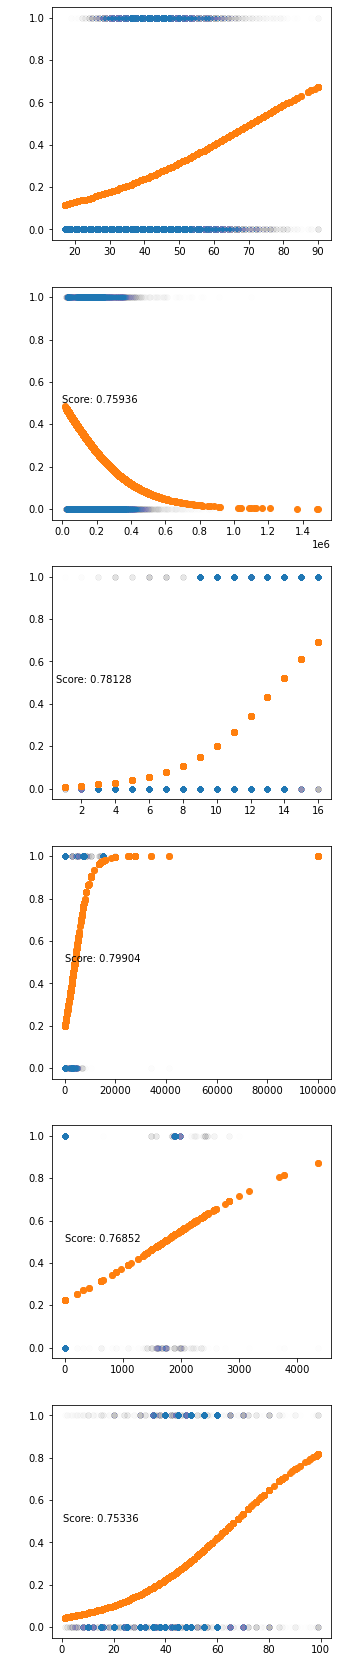

In [54]:
# Let's plot continuous and integer variables against income levels to see the
# distributions.

# We'll graph each with a fitting logistic regression to see how strong each
# variable can model the data.

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import LogisticRegression
from scipy.special import expit

# Pick out the continuous or integer variables
cont_vars = []
for c in feats.columns:
    if feats[c].dtype in ["int64"]:
        cont_vars.append(c)

# Create a figure to hold all the graphs.
fig: plt.Figure = plt.figure(figsize=(5, len(cont_vars) * 5))
gs = GridSpec(nrows=len(cont_vars), ncols=1)

for i, v in enumerate(cont_vars):

    data = feats[v].to_numpy().reshape(-1, 1)
    
    lgr = LogisticRegression()
    lgr.fit(data, targs)
    loss = expit(data * lgr.coef_ + lgr.intercept_).ravel()

    ax = fig.add_subplot(gs[i, 0])
    ax.scatter(
        data,
        targs,
        alpha=0.005
    )

    ax.scatter(
        data,
        loss,
    )

    ax.annotate(text=f"Score: {lgr.score(data, targs)}", xy=(0.5, 0.5))

It looks like none of these variables on their own do a much better job than a
a simple random guess. The most accurate integer feature can do past the base
75% prediction is a 5% increase, at 80%.

In [63]:
# Let's see how all continuous features can do.abs

import sklearn.metrics as met

lgr = LogisticRegression()
lgr.fit(feats[cont_vars], targs)
preds = lgr.predict(feats[cont_vars])

print(met.confusion_matrix(targs, preds))
print()
print(met.confusion_matrix(targs, preds) / len(targs))

[[18352   632]
 [ 4382  1634]]

[[0.73408 0.02528]
 [0.17528 0.06536]]


It looks like the logistic regression against all factors is marginally better
than just guessing. Marginally - 5% on the training data.

It struggles the most on Type 2 errors - false negatives that should be categorized
as true negatives.

It's not great, but we'll call it a solid first attempt. Better than nothing,
huh?

In [70]:
out = pd.DataFrame(lgr.predict(tst_feats[cont_vars]), columns = ["Prediction"])
out.set_index(test_df["ID"], inplace=True)

out.to_csv("attempt01.csv")